In [1]:
%matplotlib inline

In [3]:
# Some initial imports
from __future__ import division, print_function
import pandas as pd
import numpy as np
import os

from ggplot import *

In [6]:
# Sample titles with corresponding barcodes
samples = {
    's9': ['ATCACG', 'ACAGTG'],
    's9+bcm': ['CGATGT', 'GCCAAT'],
    's17': ['TTAGGC', 'GATCAG'],
    's17+bcm': ['TGACCA', 'TAGCTT'],
    's19': ['CAGATC','GGCTAC'],
    's19+bcm': ['ACTTGA', 'CTTGTA']
}

# Barcodes
barcodes = ['ATCACG', 'ACAGTG', 'CGATGT', 'GCCAAT', 'TTAGGC', 'GATCAG', 'TGACCA', 'TAGCTT', 'CAGATC','GGCTAC', 'ACTTGA', 'CTTGTA']

In [8]:
import urllib

# Download data files

DOMAIN = 'http://ngs.nudlerlab.info'
file_tpl = '{0}.UTR_heatmap.txt.gz'

for barcode in barcodes:
    remote = urllib.URLopener()
    file_name = file_tpl.format(barcode)
    try:
        print("Trying {0}".format(file_name))
        remote.retrieve("{0}/{1}".format(DOMAIN, file_name), "../data/{0}".format(file_name))
    except IOError:
        print("\terror downloading {0}. Skipping.".format(file_name))

Trying ATCACG.UTR_heatmap.txt.gz
Trying ACAGTG.UTR_heatmap.txt.gz
Trying CGATGT.UTR_heatmap.txt.gz
Trying GCCAAT.UTR_heatmap.txt.gz
Trying TTAGGC.UTR_heatmap.txt.gz
	error downloading TTAGGC.UTR_heatmap.txt.gz. Skipping.
Trying GATCAG.UTR_heatmap.txt.gz
	error downloading GATCAG.UTR_heatmap.txt.gz. Skipping.
Trying TGACCA.UTR_heatmap.txt.gz
	error downloading TGACCA.UTR_heatmap.txt.gz. Skipping.
Trying TAGCTT.UTR_heatmap.txt.gz
	error downloading TAGCTT.UTR_heatmap.txt.gz. Skipping.
Trying CAGATC.UTR_heatmap.txt.gz
	error downloading CAGATC.UTR_heatmap.txt.gz. Skipping.
Trying GGCTAC.UTR_heatmap.txt.gz
	error downloading GGCTAC.UTR_heatmap.txt.gz. Skipping.
Trying ACTTGA.UTR_heatmap.txt.gz
	error downloading ACTTGA.UTR_heatmap.txt.gz. Skipping.
Trying CTTGTA.UTR_heatmap.txt.gz
	error downloading CTTGTA.UTR_heatmap.txt.gz. Skipping.


In [9]:
# Load the data

data_tpl = '../data/{0}.UTR_heatmap.txt.gz'
data = {}

for barcode in barcodes:
    try:
        data[barcode] = np.loadtxt(data_tpl.format(barcode), delimiter='\t')
    except IOError:
        pass

In [10]:
data

{'ACAGTG': array([[ 1.,  1.,  7., ...,  0.,  0.,  0.],
        [ 1.,  6.,  8., ...,  0.,  0.,  0.],
        [ 1.,  6.,  8., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 2.,  2.,  2., ...,  0.,  0.,  0.]]),
 'ATCACG': array([[  2.,   2.,   2., ...,   0.,   0.,   0.],
        [  2.,  10.,  11., ...,   0.,   0.,   0.],
        [  2.,  10.,  11., ...,   0.,   0.,   0.],
        ..., 
        [  1.,   1.,   1., ...,   0.,   0.,   0.],
        [  1.,   1.,   1., ...,   0.,   0.,   0.],
        [  1.,   1.,   1., ...,   0.,   0.,   0.]]),
 'CGATGT': array([[ 3.,  5.,  5., ...,  0.,  0.,  0.],
        [ 4.,  6.,  6., ...,  0.,  0.,  0.],
        [ 4.,  6.,  6., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  1.,  2., ...,  0.,  0.,  0.],
        [ 1.,  1.,  2., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.]]),
 'GCCAAT': array([[ 5.,  6.,  8., ...,  0.,  0.,  0.],
        [ 4.,  7.,  8

In [11]:
# import more stuff we'll need for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import math

In [14]:
# Our main plotting function
# Takes an np array as data source and does the plotting using vanilla matplotlib
# Remember that image is nothing more than an array of floats (intensities)

def plot_utr_heatmap(data, title=None, cmap=cm.OrRd, ylim=[1750, 1500], orientation='vertical'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    utr = data.copy()
    utr.sort(axis=0)
    max_val = np.max(utr)
    midpoint = math.ceil(max_val / 2)
    fig, ax = plt.subplots(figsize=(18,18))
    im = ax.imshow(utr,cmap=cmap)
    if title:
        ax.set_title(title, fontsize=20)
    else:
        ax.set_title("Read depth at 5'UTR", fontsize=20)
    ax.set_ylim(ylim)
    ax.set_xlabel('Position from TSS', fontsize=20)
    ax.get_yaxis().set_ticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, ticks=[0,midpoint,max_val], orientation=orientation)
    cbar.ax.invert_yaxis()
    cbar.ax.set_xticklabels(['0', '{0}'.format(int(midpoint)), '{0}'.format(int(max_val))], fontsize=20)
    plt.show()

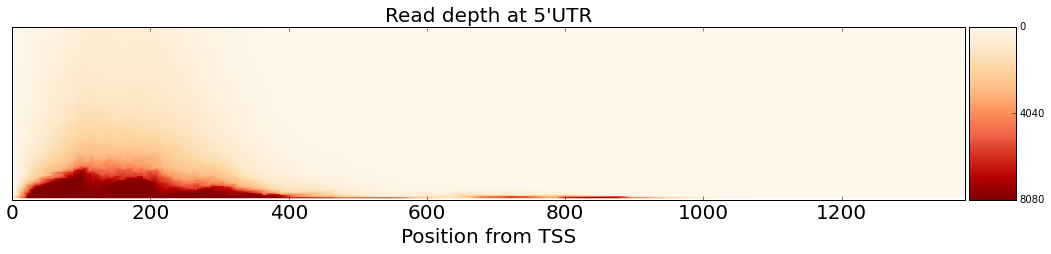

In [13]:
plot_utr_heatmap(data['ACAGTG'])

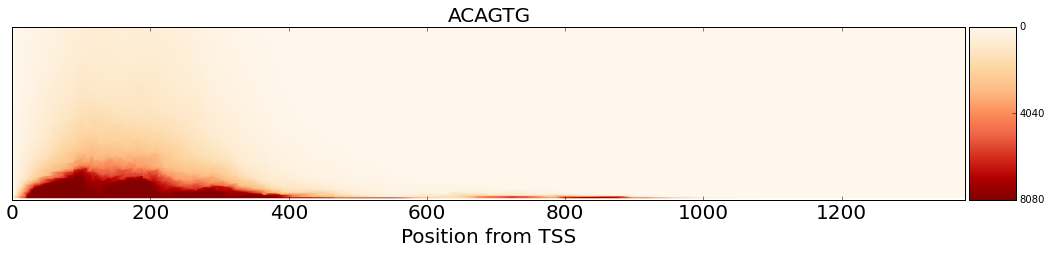

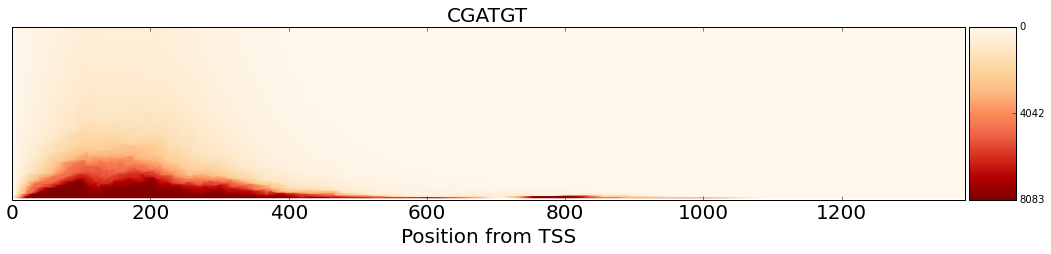

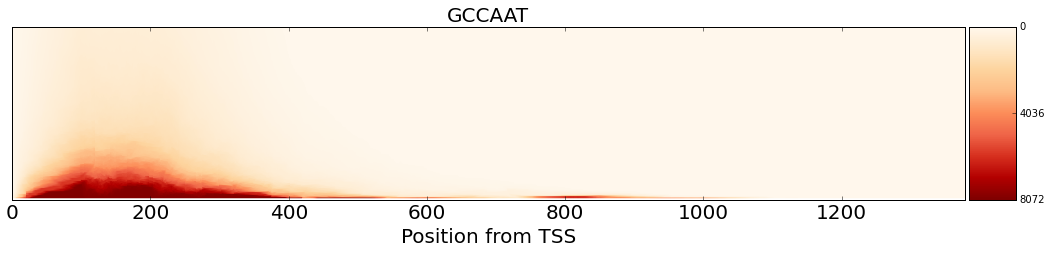

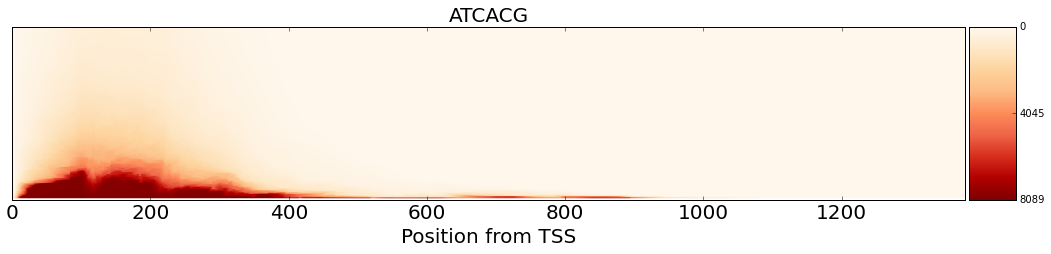

In [15]:
for barcode,heatmap in data.items():
    plot_utr_heatmap(heatmap, title=barcode)

In [16]:
# Ok, we do see some changes but let's try to quantify them

win = 20 # window size for computing rolling mean
quart = 0.5 # quartile to sum

df = pd.DataFrame(np.sort((data['ACAGTG'] + data['ATCACG']) / 2., axis=0))
mask = (df > np.max(df.max()) * quart)
col1 = pd.rolling_mean(df[mask].cumsum()[-1:].transpose(), win)

df = pd.DataFrame(np.sort((data['CGATGT'] + data['GCCAAT']) / 2., axis=0))
mask = (df > np.max(df.max()) * quart)
col2 = pd.rolling_mean(df[mask].cumsum()[-1:].transpose(), win)

In [17]:
df1 = pd.DataFrame()
df1['sum'] = col1[1747]
df1['BCM'] = '-'
df1['pos'] = df1.index

df2 = pd.DataFrame()
df2['sum'] = col2[1747]
df2['BCM'] = '+'
df2['pos'] = df2.index

df = pd.concat([df1,df2])
df = df.dropna().reset_index(drop=True)
df['sum'] = df['sum'] / 1e5

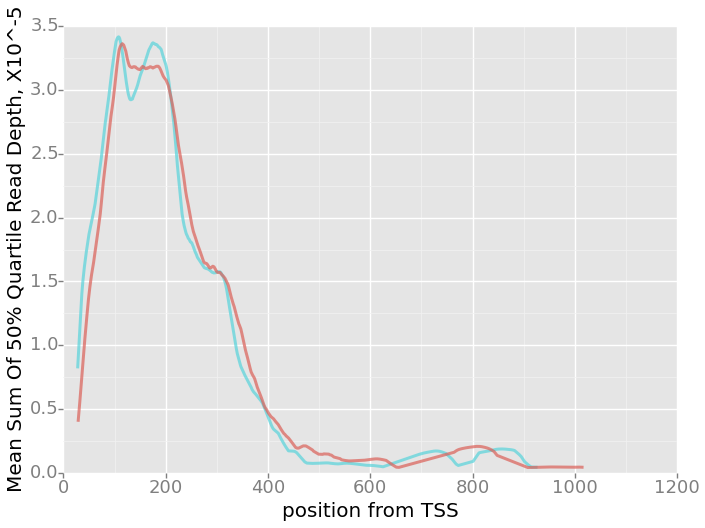

<ggplot: (8754709319345)>


In [18]:
p = ggplot(df, aes(x='pos', y='sum', color='BCM')) \
    + geom_line(size=3, alpha=0.7) \
    + scale_x_continuous(name="position from TSS") \
    + scale_y_continuous(name="Mean sum of 50% quartile read depth, x10^-5") \
    + theme(axis_title=element_text(size=20),
            axis_text=element_text(size=18)) 
    
print p